# Statistical study of the value of 1 euro
Statistical study of the value of 1 EUR in USD from 2000 to 2022.  
Data is from https://fred.stlouisfed.org/series/DEXUSEU .

## Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_predict
%matplotlib inline

In [2]:
df=pd.read_csv('eur_to_usd.csv', index_col="DATE", infer_datetime_format=True, parse_dates=True)

**Preprocessing data**

In [3]:
df=df[df.VALUE!='.']
df=df.astype(float)
start_date = df.index.min()
end_date = df.index.max()
full_index = pd.date_range(start=start_date, end=end_date, freq='D')
df = df.reindex(full_index)
df.fillna(method='ffill', inplace=True)
df.index = pd.to_datetime(df.index)
df = df.asfreq('D')

## Linear time series

**Plot**

<AxesSubplot:title={'center':'Value of 1 EUR in USD'}>

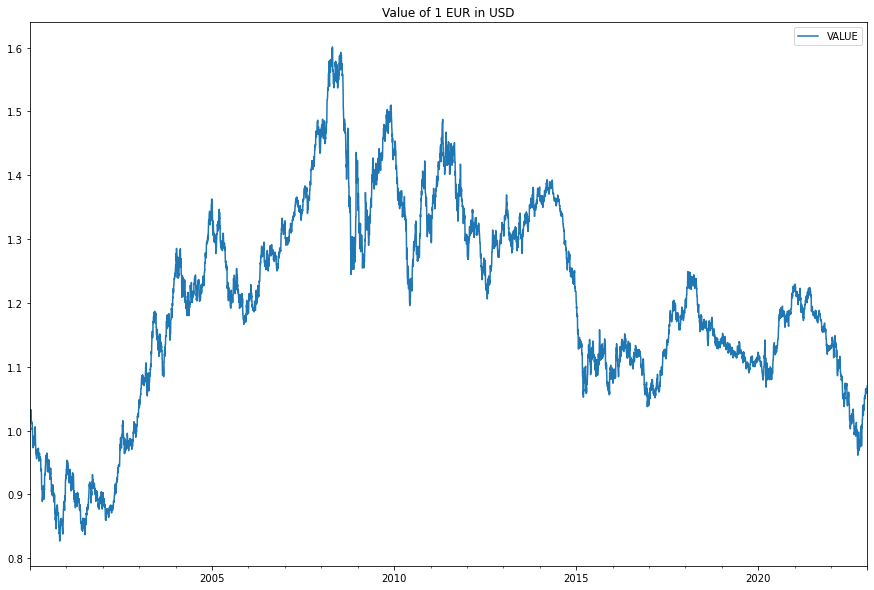

In [4]:
df[["VALUE"]].plot(figsize=(15,10), title="Value of 1 EUR in USD")

In the long term, we can see that the value of 1 EUR grows from 2000 to 2009 then starts to decrease. At the end, the value of 1 euro is nearly the same as its value in early 2000s.  
In the short term, we see, from the numerous small fluctuations in the plot, that the value has a high volatily.

**Hodrick-Prescott Filter**

In [5]:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(df['VALUE'])

In [6]:
hp_df=df.copy()
hp_df['noise']=ts_noise
hp_df['trend']=ts_trend

<AxesSubplot:title={'center':'Trend'}>

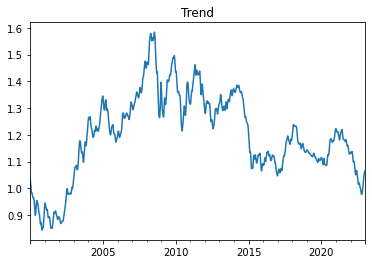

In [7]:
ts_trend.plot(title="Trend")

<AxesSubplot:title={'center':'Value vs. Trend of 1 EUR'}>

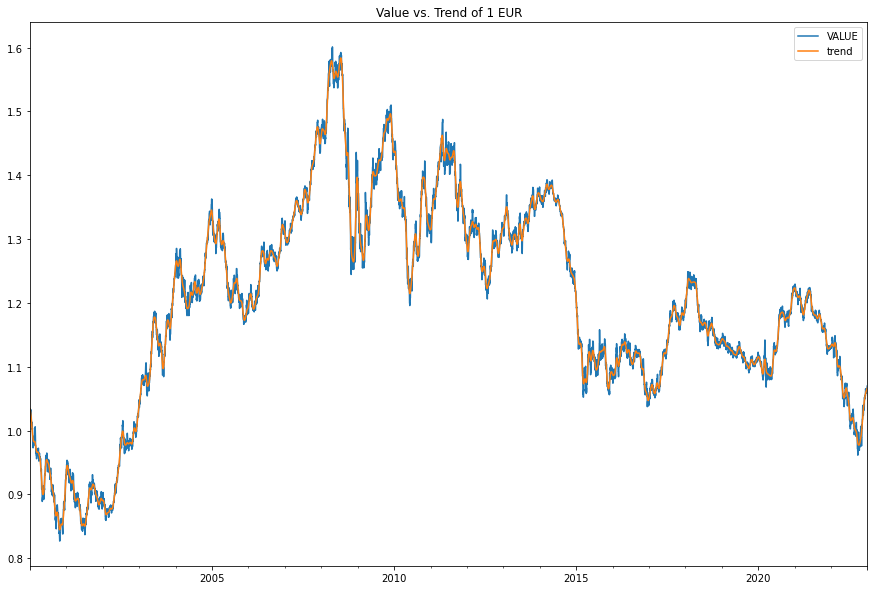

In [8]:
hp_df[["VALUE", "trend"]].plot(figsize=(15,10), title="Value vs. Trend of 1 EUR")

The Hodrick-Prescott Filter deletes small fluctuations.   
In the long term, the trend plot allows us to confirm that there is a general icrease then a decrease in the value of an euro relatively to usd.  
In the short term, we can still see some fluctuations that may correspond to monthly changes.

<AxesSubplot:title={'center':'Noise'}>

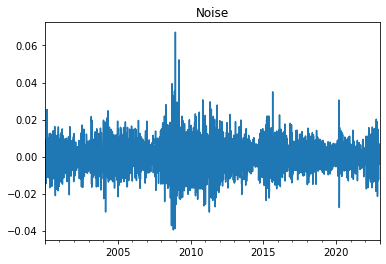

In [9]:
ts_noise.plot(title="Noise")

We can see that there is a huge singular noise in 2009. This can be explained by the crisis of 2008. The crisis affected many countries, including the US and European Union (EU) member states, causing a lot of uncertainty in the financial markets.    
There is also a singular noise in 2020. This is surely due to Covid crisis in Europe.

## Seasonality

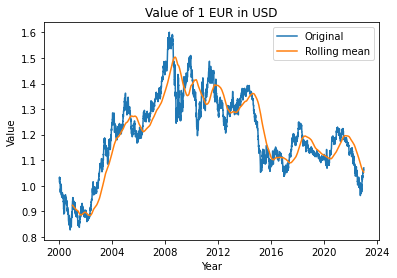

In [10]:
rolling_mean = df['VALUE'].rolling(window=365).mean()

plt.plot(df.index, df['VALUE'], label='Original')
plt.plot(rolling_mean.index, rolling_mean, label='Rolling mean')
plt.legend(loc='best')
plt.title('Value of 1 EUR in USD')
plt.xlabel('Year')
plt.ylabel('Value')
plt.show()

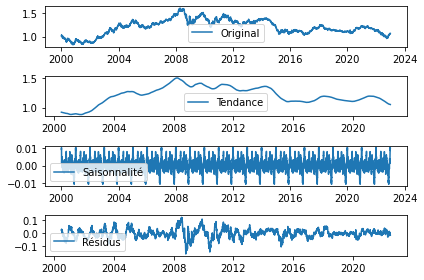

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['VALUE'], model='additive', period=365)

# Obtenez les composantes saisonnières, tendancielles et résiduelles
seasonal = decomposition.seasonal
trend = decomposition.trend
residual = decomposition.resid

# Tracez les composantes
import matplotlib.pyplot as plt

plt.subplot(411)
plt.plot(df['VALUE'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Tendance')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Saisonnalité')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Résidus')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Stationarity

**ADF**

In [12]:
adf_p_value = adfuller(df, autolag='AIC')[1]
print('p-value:', adf_p_value)

p-value: 0.3798831484602285


The p-value is 0.38>0.05 . The data doesn't seem to be stationnary.  
Let's use a different test to be sure.

**KPSS**

In [13]:
kpss_p_value = kpss(df)[1]
print(f"P-value: {kpss_p_value}")

P-value: 0.01


C:\Users\idris\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Again, KPSS test shows that data is not stationary. Let's differentiate.

In [14]:
adf_p_value = adfuller(df.diff().dropna(), autolag='AIC')[1]
kpss_p_value = kpss(df.diff().dropna())[1]
print('After differentiating once:')
print(f"ADF P-value: {adf_p_value}")
print(f"KPSS P-value: {kpss_p_value}")

After differentiating once:
ADF P-value: 0.0
KPSS P-value: 0.1


C:\Users\idris\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Differentiating once makes the data stationnary.

**PACF and ACF**

C:\Users\idris\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


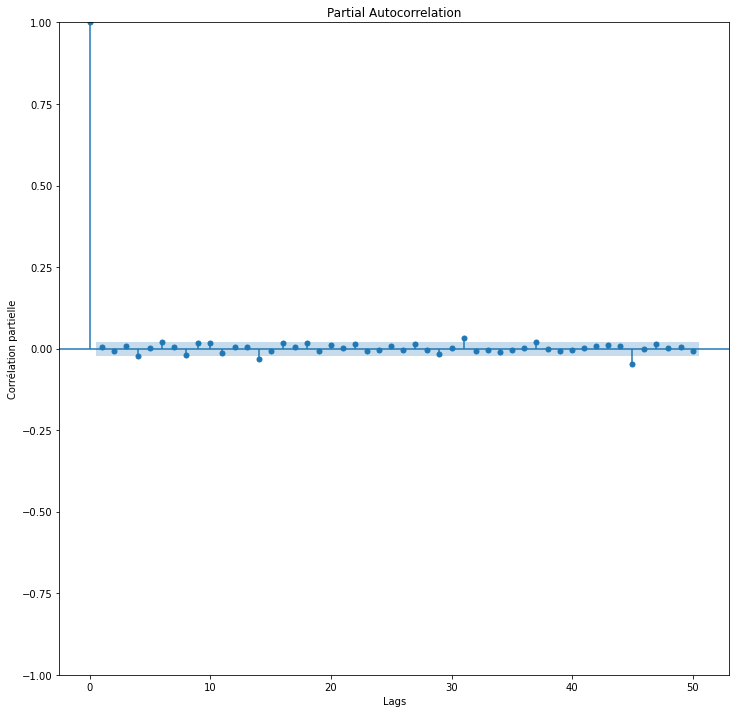

In [15]:
fig, ax = plt.subplots(figsize=(12,12))
plot_pacf(df.diff().dropna(), lags=50, ax=ax)
plt.xlabel('Lags')
plt.ylabel('Corrélation partielle')
plt.show()

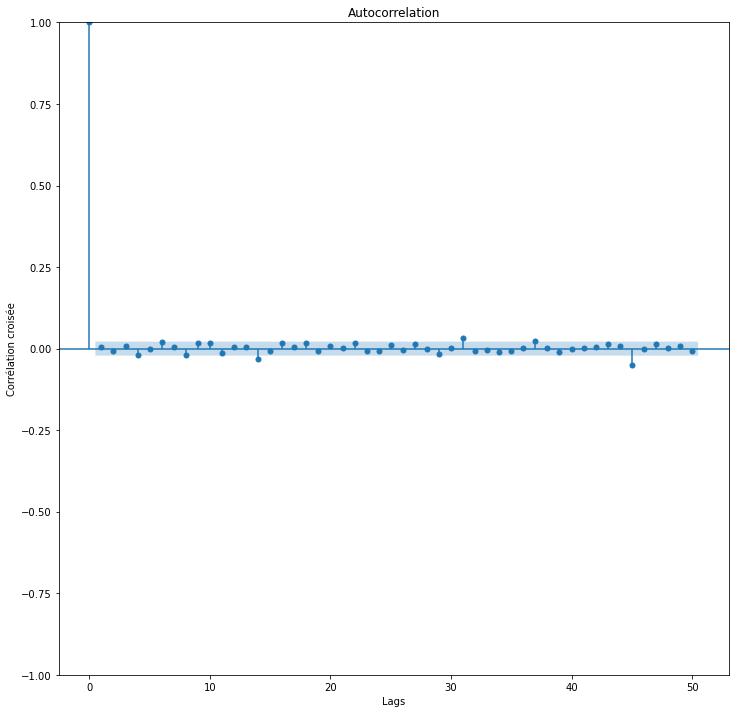

In [16]:
fig, ax = plt.subplots(figsize=(12,12))
plot_acf(df.diff().dropna(), lags=50, ax=ax)
plt.xlabel('Lags')
plt.ylabel('Corrélation croisée')
plt.show()

According to these plots, we take p=q=1

## Modèle ENCORE A CHOISIR

In [22]:
diff=df.diff().dropna()
min_bic, best_p, best_q = np.inf, 1, 1
for p in range(5):
    for q in range(5):
        model = sm.tsa.ARIMA(diff, order=(p,0,q))
        results = model.fit()
        bic = results.bic
        if bic < min_bic:
            min_bic = bic
            best_p, best_q = p, q


C:\Users\idris\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\idris\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\idris\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\idris\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\idris\anaconda3\lib\site-packages\statsmodels\base\model

In [23]:
print(best_q)

0


In [24]:
model = sm.tsa.ARIMA(diff, order=(best_p,0,best_q))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  VALUE   No. Observations:                 8397
Model:                          ARIMA   Log Likelihood               31097.163
Date:                Tue, 07 Mar 2023   AIC                         -62190.327
Time:                        11:44:02   BIC                         -62176.255
Sample:                    01-04-2000   HQIC                        -62185.522
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.496e-06   6.51e-05      0.023      0.982      -0.000       0.000
sigma2      3.553e-05   2.68e-07    132.499      0.000     3.5e-05    3.61e-05
Ljung-Box (L1) (Q):                   0.32   Jarque-

<AxesSubplot:title={'center':'50 Day Futures Price Forecast'}>

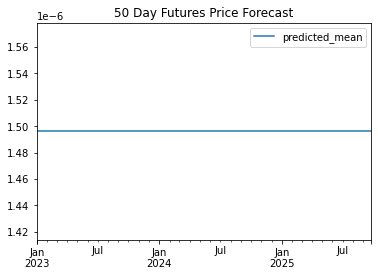

In [25]:
pd.DataFrame(results.forecast(steps=1000)).plot(title="50 Day Futures Price Forecast")

## GARCH processes